<a href="https://colab.research.google.com/github/AftabUdaipurwala/Deeplearning/blob/main/Text_Classification_Using_BERT_%26_Tensorflow_%7C_Deep_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text

In [2]:
import tensorflow_hub as hub
import tensorflow_text as text
import cv2
import pandas as pd
import numpy as np
from sklearn import linear_model
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,10)
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import tensorflow_datasets as tfds

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/MyDrive/py-master/DeepLearningML/47_Text_Classifcation_BERT/'

spam_ham_dataset.csv


In [5]:
df = pd.read_csv('/content/drive/MyDrive/py-master/DeepLearningML/47_Text_Classifcation_BERT/spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
df= df.drop(df.columns[[0]], axis=1)
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
df.groupby('label').describe()

label_num                                   
          count mean  std  min  25%  50%  75%  max
label                                             
ham      3672.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
spam     1499.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [8]:
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [9]:
 1499/(1499+3672) # but i wont be doing down sampling, SMOTE or oversmapling minority class as it is not required i feel

0.2898859021465867

In [10]:
df_spam = df[df['label']=='spam']
df_ham = df[df['label']=='ham']
df_spam.shape, df_ham.shape

((1499, 3), (3672, 3))

In [11]:
from sklearn.model_selection import train_test_split
x= df['text']
y=df['label_num']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state=1,test_size=0.2,stratify=y)

In [12]:
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((4136,), (4136,), (1035,), (1035,))

In [13]:
xtrain.head(5)

4682    Subject: re : tuesday , december 26 th\r\ni ' ...
1572    Subject: fyi\r\njust wanted to let you know th...
379     Subject: re : rate for tenaska deal\r\ndaaah !...
1259    Subject: revision # 1 - hpl nom for sept . 2 ,...
3790    Subject: mcmullen outage\r\n- - - - - - - - - ...
Name: text, dtype: object

In [14]:
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [15]:
bert_preprocess= hub.KerasLayer(preprocess_url)
bert_encoder= hub.KerasLayer(encoder_url)

In [16]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']


In [17]:
get_sentence_embedding(['i love python','i love chicken'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.861153  , -0.23277396,  0.3820118 , ...,  0.4286719 ,
        -0.6130614 ,  0.8604872 ],
       [-0.78476053, -0.16920103,  0.6602368 , ...,  0.5279717 ,
        -0.55726993,  0.8157061 ]], dtype=float32)>

In [18]:
e= get_sentence_embedding(['banana','apple','mango','elon musk','jeff bezos','bill gates'])

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([e[0],e[1]]))

[[0.99999976 0.96597767]
 [0.96597767 0.99999964]]


In [20]:
# bert layers

text_input = tf.keras.layers.Input(shape=(), name='text', dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [21]:
# neural network layers, making it functional style neural network

l= tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l= tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

# construct a final model now
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [24]:
model.fit(xtrain, ytrain, epochs=10)

Epoch 1/10
130/130 [==============================] - 96s 654ms/step - loss: 0.5391 - accuracy: 0.7415 - precision: 0.6826 - recall: 0.2027
Epoch 2/10
130/130 [==============================] - 86s 659ms/step - loss: 0.4573 - accuracy: 0.7996 - precision: 0.7965 - recall: 0.4145
Epoch 3/10
130/130 [==============================] - 85s 656ms/step - loss: 0.4076 - accuracy: 0.8327 - precision: 0.8458 - recall: 0.5171
Epoch 4/10
130/130 [==============================] - 85s 655ms/step - loss: 0.3705 - accuracy: 0.8484 - precision: 0.8557 - recall: 0.5738
Epoch 5/10
130/130 [==============================] - 85s 656ms/step - loss: 0.3481 - accuracy: 0.8566 - precision: 0.8499 - recall: 0.6138
Epoch 6/10
130/130 [==============================] - 85s 656ms/step - loss: 0.3212 - accuracy: 0.8798 - precision: 0.8718 - recall: 0.6864
Epoch 7/10
130/130 [==============================] - 87s 668ms/step - loss: 0.3017 - accuracy: 0.8854 - precision: 0.8695 - recall: 0.7114
Epoch 8/10
130/130 [

In [25]:
model.evaluate(xtest,ytest)

33/33 [==============================] - 23s 654ms/step - loss: 0.2517 - accuracy: 0.9121 - precision: 0.9004 - recall: 0.7833


[0.2517405152320862,
 0.9120773077011108,
 0.9003831148147583,
 0.7833333611488342]

In [26]:
ypredicted = model.predict(xtest)
ypredicted = ypredicted.flatten()

In [27]:
import numpy as np
ypredicted = np.where(ypredicted>0.5,1,0)
ypredicted

array([1, 0, 0, ..., 1, 0, 1])

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(ytest,ypredicted)
cm

array([[709,  26],
       [ 65, 235]])

Text(159.0, 0.5, 'Actual')

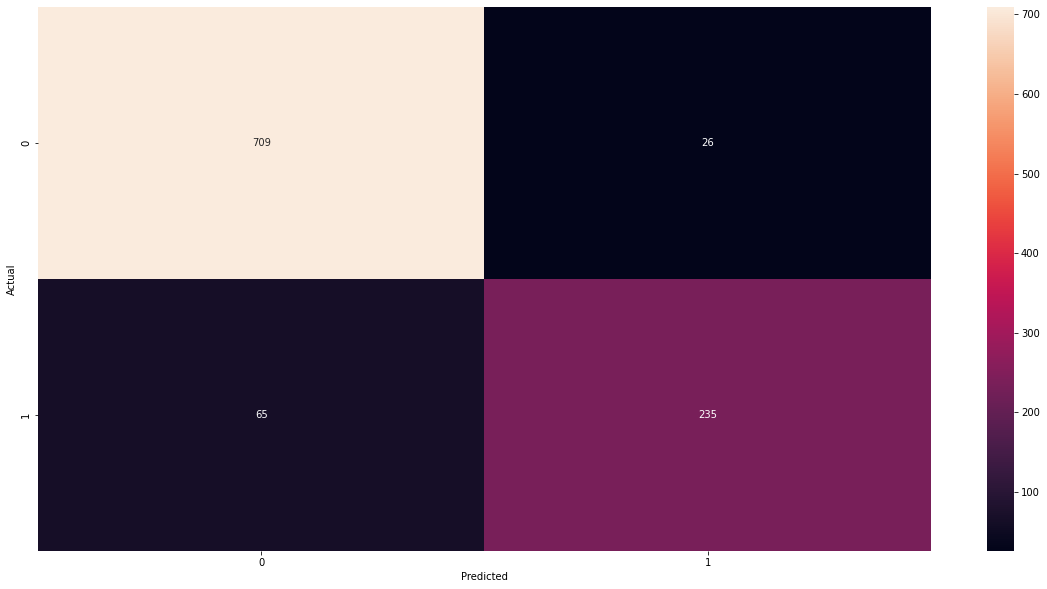

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [30]:
print(classification_report(ytest,ypredicted))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       735
           1       0.90      0.78      0.84       300

    accuracy                           0.91      1035
   macro avg       0.91      0.87      0.89      1035
weighted avg       0.91      0.91      0.91      1035

